In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR,ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch import Tensor

import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

### Dataset customisée par entraîner un modèle d'auto encodeur

In [13]:
class AE_Dataset(Dataset):

    """Cette classe à été créée afin de créer facilement un DataLoader de pytorch
    """
    def __init__(self, data):

        super(AE_Dataset,self).__init__()

        #La target d'un auto encoder est lui le donnée initial car n'oublions pas que l'objectif
        #de l'auto encodeur c'est de reconstituer la donnée initiale

        self.data = np.copy(data)
        self.targets = np.copy(data)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return torch.tensor(self.data[index],dtype=torch.float32), torch.tensor(self.targets[index],dtype=torch.float32)


In [14]:
# torch.manual_seed(42)
# batch, m_feature= 3, 4
# input = torch.randn(batch, m_feature)
# # Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# # as shown in the image below
# # layer_norm = nn.LayerNorm([batch, m_feature])
# layer_norm = nn.LayerNorm(batch)
# output = layer_norm(input)

# print(input)
# print(output)

In [15]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df

def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    precision_recall_display(ytrue, ypred)
    roc_curve_disolay(ytrue, ypred)
    scores(ytest,ypred)

def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1

    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1

    elif isinstance(target,np.ndarray):
        target[target==1]=0
        target[target==-1]=1
    return target

In [34]:
class CustomDataset:

    def __init__(self, file_path, scaler,test_size=0.15, random_state=42):

        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = scaler

        self.data = None
        self.target = None

        # Chargement et prétraitement de la donnée
        self._load_data()
        self._preprocess_data()
        self._split_data()

        self.xtrain = self._xtrain # ce sont uniquement les données normales quui seront entraînées avec l'auto encoder
        self.ytrain = self.xtrain # La target d'un auto encoder est lui le donnée initial car n'oublions pas que l'objectif
                                # de l'auto encodeur c'est de reconstituer la donnée initiale

        # Par contre les données de test devront à la fois contenir les données normales et les données anormales
        #Ainsi les données de test seront la concatenation entre les données normales reservées pour le test et les données contenant que des 1

        self.xtest = pd.concat([self._xtest, self.data[self.target==1]], axis=0)
        self.ytest = pd.concat([self._ytest, self.target[self.target==1]], axis=0)

        self.xtest.reset_index(drop=True, inplace=True)
        self.ytest.reset_index(drop=True, inplace=True)

        # Note : ytrain utilisé comme target lors de l'entraînement n'est le même format que ytest utilisé lors de la prédiction
        # ytrain =xtrain alors que ytest =target (labels)(0 pour donnée normale et 1 pour donnée anormale)


    def get_scaler(self):
        return self.scaler

    def _load_data(self):
        self.data = pd.read_csv(self.file_path)

        self.data.drop_duplicates(keep="last", inplace=True)
        self.target = self.data["class"]
        self.data.drop(["class"], axis=1,inplace=True)


    def _preprocess_data(self):

        # Avec un modèle de réseaux de neurones profond, l'on n'est pas obligé de pré-traiter la donnée
        if self.scaler is not None:

            data_scaled_array = self.scaler.fit_transform(self.data)
            # self.data['Amount']=self.scaler.fit_transform(self.data['Amount'].values.reshape(self.data.shape[0],-1))

            #Il est impératif d'ajouter l'argument index lors de la créaction d'un dataframe à partir d'un numpy array
            # Dans notre cas, data_scaled_array est un tableau numpy. si l'argument "index" n'est pas ajouté alors l'index par défaut sera
            # RangeIndex. Le RangeIndex est incompatible avec la Index. Par exemple il sera impossible de concater deux dataframes
            # Ou un dataframe et une serie dont l'un possède Index et l'autre RangeIndex
            self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns,index=self.data.index)


    def _split_data(self):

        self._xtrain, self._xtest, self._ytrain, self._ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

### Sampling

In [17]:
class Sampling(nn.Module):

    def __init__(self):
        super(Sampling,self).__init__()

    def forward(self,mean: Tensor,log_var: Tensor) -> Tensor:
        batch = mean.shape[0]
        n_features = mean.shape[1]
        epsilon = torch.randn(batch, n_features).to(mean.device)
        return mean + torch.exp(0.5 * log_var) * epsilon # On mettre le second tensor dans le même device que le premier tensor

## Encoder Layer

In [18]:
class Encoder(nn.Module):

    def __init__(self,input_size: int, latent_size: int,dropout: float,device: str="cuda") -> None:

        super(Encoder,self).__init__()

        self.fc1=nn.Linear(in_features=input_size,out_features=25)
        self.residual1=nn.Linear(in_features=input_size,out_features=20)
        self.layer_norm1=nn.LayerNorm(25)
        self.relu1=nn.ReLU()
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=25,out_features=20)
        self.layer_norm2=nn.LayerNorm(20)
        self.relu2=nn.ReLU()
        self.residual2=nn.Linear(in_features=20,out_features=latent_size)
        self.fc3=nn.Linear(in_features=20,out_features=15)
        self.layer_norm3=nn.LayerNorm(15)
        self.relu3=nn.ReLU()
        self.dropout2=nn.Dropout(dropout)


        self.mean = nn.Linear(in_features=15,out_features=latent_size)
        self.log_var = nn.Linear(in_features=15,out_features=latent_size)

        self.device= torch.device("cuda") if device=="cuda" else torch.device("cpu")


    def forward(self,inputs: Tensor) -> Tensor:
        x=self.relu1(self.layer_norm1(self.fc1(inputs)))
        residual1=self.residual1(inputs)
        x=self.dropout1(x)
        x= self.relu2(self.layer_norm2(self.fc2(x)+residual1))
        residual2=self.residual2(x)
        x= self.relu3(self.layer_norm3(self.fc3(x)))
        x=self.dropout2(x)

        mean=self.mean(x)
        log_var=self.log_var(x)
        z=Sampling()(mean, log_var)

        return mean,log_var,z


## Decoder Layers

In [19]:
class Decoder(nn.Module):

    def __init__(self,latent_size: int, output_size: int,dropout: float,device: str="cuda") -> None:

        super(Decoder,self).__init__()

        self.fc1=nn.Linear(in_features=latent_size,out_features=15)
        self.residual1=nn.Linear(in_features=latent_size,out_features=20)
        self.relu1=nn.LeakyReLU(0.1)
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=15,out_features=20)
        self.layer_norm3=nn.LayerNorm(20)
        self.relu2=nn.LeakyReLU(0.1)
        self.residual2=nn.Linear(in_features=20,out_features=output_size)
        self.fc3=nn.Linear(in_features=20,out_features=25)
        self.layer_norm4=nn.LayerNorm(25)
        self.relu3=nn.LeakyReLU(0.1)
        self.dropout2=nn.Dropout(dropout)

        self.fc4=nn.Linear(in_features=25,out_features=output_size)



    def forward(self,inputs: Tensor) -> Tensor:
        x=self.relu1(self.fc1(inputs))
        residual1=self.residual1(inputs)
        x=self.dropout1(x)
        x= self.relu2(self.layer_norm3(self.fc2(x) +residual1))
        residual2=self.residual2(x)
        x= self.relu3(self.layer_norm4(self.fc3(x)))
        x=self.dropout2(x)
        x=self=self.fc4(x) +residual2
        return x

## Variational AutoEncoder

In [20]:
class VariationalAutoEncoder(nn.Module):

    def __init__(self,input_size: int,latent_size: int,output_size: int,contamination: float=0.5,dropout: float=0.1,device: str="cuda") -> None:

        super(VariationalAutoEncoder,self).__init__()

        self.encoder=Encoder(input_size=input_size, latent_size = latent_size,device="cuda",dropout=0.1)
        self.latent=None
        self.mean=None
        self.log_var=None
        self.decoder=Decoder(latent_size =latent_size, output_size=output_size,device="cuda",dropout=0.1)
        self.offset=contamination

        self.device= torch.device("cuda") if device=="cuda" else torch.device("cpu")

        self.is_fitted=False

        self.total_train_curve = []
        self.recons_train_curve = []
        self.kld_train_curve = []

        self.total_val_curve = []
        self.recons_val_curve = []
        self.kld_val_curve = []

    def forward(self,inputs: Tensor) -> Tensor:
        mean,log_var,z=self.encoder(inputs)
        self.latent=z
        self.mean=mean
        self.log_var=log_var
        output=self.decoder(z)

        return mean,log_var,output


    def train_one_epoch(self,train_loader:DataLoader,optimizer,scheduler):

        """The function is use to train one epoch of the model
            Args:
                optimizer      : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function  : The loss function to use during the model training. CrossEntropyLoss and MSELoss are very often use for respectively
                                classification and regression problem
                train_loader   : A torch DataLoader which is use to iterate through the data during train step

            Return : The last loss value on the train_loader

        """
        running_loss = 0.0
        running_kld_loss=0.0
        running_recons_loss=0.0

        last_loss = {
            "kld_loss":0.0,
            "recons_loss":0.0,
            "total_loss":0.0
        }

        for batch_index, batch in enumerate(train_loader):

            optimizer.zero_grad() # Putting gradient to zero in order to accumulate upcoming gradient


            data,target=batch[0].to(self.device),batch[1].to(self.device)

            mean,log_var,outputs=self.forward(data) # Making prediction

            #Reconstition Loss
            recon_loss, kld_loss=self.loss_function(obs=target, recon=outputs, mu=mean, log_var=log_var)


            tolal_loss=recon_loss + kld_loss
            tolal_loss.backward() # Computing the gradient

            running_kld_loss+=kld_loss.item()
            running_recons_loss+=recon_loss.item()
            running_loss+=tolal_loss.item() # Accumulation loss through one epoch

            optimizer.step() # Updating weights

            if batch_index%100==99:
                last_loss["total_loss"] = running_loss/100 # Computing loss per batch
                last_loss["kld_loss"] = running_kld_loss/100
                last_loss["recons_loss"] = running_kld_loss/100
                # print("batch {} loss {}".format(batch_index+1,last_loss))

        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        # print("SGD lr %.8f -> %.8f" % (before_lr, after_lr))
        return last_loss


    def validation_one_epoch(self,validation_loader):

        """The function is used to train one epoch of the model
            Args:
                optimizer       : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function   : The loss function to use during the model validation. Same as the training one
                val_loader      : A torch DataLoader which is use to iterate through the data during validation step

            Return : The last loss value on the val_loader

        """
        avg_vloss = {
            "kld_loss":0.0,
            "recons_loss":0.0,
            "total_loss":0.0
        }

        running_loss=0.
        running_kld_loss=0.
        running_recons_loss=0.

        with torch.no_grad() :
            for batch in validation_loader:

                data,target=batch[0].to(self.device),batch[1].to(self.device)
                mean,log_var,outputs=self.forward(data) # Making prediction

                #Reconstition Loss
                recon_loss, kld_loss=self.loss_function(obs=target, recon=outputs, mu=mean, log_var=log_var)

                tolal_loss=recon_loss + kld_loss

                running_kld_loss+=kld_loss.item()
                running_recons_loss+=recon_loss.item()
                running_loss+=tolal_loss.item()


        avg_vloss["total_loss"] = running_loss/len(validation_loader) # Computing loss per batch
        avg_vloss["kld_loss"] = running_kld_loss/len(validation_loader)
        avg_vloss["recons_loss"] = running_recons_loss/len(validation_loader)

        return avg_vloss


    def loss_function(self, obs: Tensor, recon: Tensor, mu: Tensor, log_var: Tensor):

        recon_loss = nn.MSELoss(reduction='mean')(recon, obs)

        kld_loss = -0.5 * torch.mean(1 + log_var - mu**2 - log_var.exp())

        return recon_loss, kld_loss


    def predict(self, dataloader,loss_fn=nn.MSELoss(reduction='none')):
        assert self.is_fitted==True, "Le modèle n'est pas encore entraîné donc ne peut pas faire de prédiction"
        return self.decision_function(dataloader,loss_fn)


    def decision_function(self,dataloader: DataLoader,loss_fn):

        dataframe=self.compute_score_sample(dataloader,loss_fn)
        dataframe.loc[-dataframe["score_sample"] < (-dataframe["score_sample"]).quantile(self.offset), "label"] = -1

        return dataframe['label']

    def score_sample(self,dataloader: DataLoader,loss_fn):

        dataframe=self.compute_score_sample(self,dataloader,loss_fn)

        return dataframe["score_sample"]

    def compute_score_sample(self,dataloader: DataLoader,loss_fn):

        assert loss_fn.reduction=='none',"La fonction pour le calcul des erreurs de reconstitution ne possède pas les bonne argument"

        reconstition_errors=[]
        with torch.no_grad() :
            for batch in dataloader:

                data,target=batch[0].to(self.device),batch[1].to(self.device)
                mean,log_var,outputs=self.forward(data) # Making prediction

                loss=loss_fn(outputs,target) # Computing the loss

                for item in loss:
                    reconstition_errors.append(torch.sum(item).item())


        dataframe=pd.DataFrame({
            "score_sample" : reconstition_errors,
            "label" :[1 for _ in range(len(reconstition_errors))]
        })

        return dataframe


    def fit(self,train_loader,validation_loader,optimizer,scheduler,epochs=100,device="cuda"):
        """The function is used to train the model through many epochs
            Args:
                optimizer             : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                train_loader          : A torch DataLoader which is use to iterate through the data during train step
                loss_function         : The loss function to use during the model validation. Same as the training one
                validataion_loader    : A torch DataLoader which is use to iterate through the data during validation step

            Return : No return

        """
        self.to(self.device)
        best_avg_vloss=1_000_000_000
        for epoch in range(epochs):
            # print("\n")
            print("EPOCHS : {}".format(epoch +1))
            self.train(True) # Activate training mode
            avg_loss=self.train_one_epoch(train_loader,optimizer,scheduler) # training the model on an epoch

            self.eval() # Setting the evaluation mode so that no gradient will be compute, that will save forward pass time
            avg_vloss=self.validation_one_epoch(validation_loader) # Evalution the model after one epoch
            # if epoch%10==0:
            print(f"total_Loss {avg_loss['total_loss']} vs total_Validation_loss  {avg_vloss['total_loss']}")
            # print(f"recons_Loss {avg_loss['recons_loss']} vs recons_Validation_loss  {avg_vloss['recons_loss']}")
            # print(f"kld_loss_Loss {avg_loss['kld_loss']} vs kld_loss_Validation_loss  {avg_vloss['kld_loss']}")

            self.total_train_curve.append(avg_loss['total_loss'])
            self.recons_train_curve.append(avg_loss['recons_loss'])
            self.kld_train_curve.append(avg_loss['kld_loss'])
            self.total_val_curve.append(avg_vloss['total_loss'])
            self.recons_val_curve.append(avg_vloss['recons_loss'])
            self.kld_val_curve.append(avg_vloss['kld_loss'])


            if avg_loss['total_loss'] < best_avg_vloss :
                best_avg_vloss=avg_loss['total_loss']
                #model_path='/home/dah/timeSeries/time_series_forcasting/models/model_{}'.format(datetime.now().strftime('%Y%m%d_%H%'))
                #torch.save(self.cpu().state_dict(),model_path)
                self.to(self.device)
                self.to(self.device)
        self.is_fitted=True

        return {
            "total_train_curve" : self.total_train_curve,
            "recons_train_curve" : self.recons_train_curve,
            "kld_train_curve": self.kld_train_curve,
            "total_val_curve" : self.total_val_curve,
            "recons_val_curve" : self.recons_val_curve,
            "kld_val_curve": self.kld_val_curve
        }


In [21]:
# Reprodductibilité
torch.manual_seed(42)

# Creation Dataset
file_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv"
#file_path = "/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv"
dataset = CustomDataset(file_path=file_path,scaler=MinMaxScaler())

xtrain, ytrain = dataset.get_train_data()
xtest, ytest = dataset.get_test_data()


#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_train_dataset = AE_Dataset(xtrain)
pytorch_test_dataset = AE_Dataset(xtest)
train_loader=DataLoader(dataset=pytorch_train_dataset,batch_size=100,num_workers=14)
test_loader=DataLoader(dataset=pytorch_test_dataset,batch_size=10,num_workers=14)

#Creation de modeèle
model=VariationalAutoEncoder(input_size=29,latent_size=10,output_size=29,contamination=0.02,dropout=0.3,device="cuda")

#Creation des paramètres d'entrînement du modèle
optimizer=optim.SGD(lr=1e-2, params=model.parameters(),momentum=0.9) # Optimiseur
scheduler = LinearLR(optimizer, start_factor=1e-1, end_factor=1e-4, total_iters=100) # Permet de changer le learning rate au cours de l'apprentissage

                                                                                    #Plus on se rapproche du minimun plus le learning devient faible afin d'éviter les rebond et d'assurer la convergence vers le minimum


history=model.fit(train_loader,test_loader,optimizer,scheduler,epochs=100)#Entraînement du modèle



EPOCHS : 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


total_Loss 1.6264097531326116 vs total_Validation_loss  0.011023789330374373
EPOCHS : 2
total_Loss 0.44946336540393533 vs total_Validation_loss  0.006265031109721102
EPOCHS : 3
total_Loss 0.29133612735196945 vs total_Validation_loss  0.00470022315636137
EPOCHS : 4
total_Loss 0.21321351315826179 vs total_Validation_loss  0.003915786442658898
EPOCHS : 5
total_Loss 0.16710016634780914 vs total_Validation_loss  0.003457188822350034
EPOCHS : 6
total_Loss 0.13749748614616691 vs total_Validation_loss  0.0031604401725166924
EPOCHS : 7
total_Loss 0.11758808283135296 vs total_Validation_loss  0.002951015788444221
EPOCHS : 8
total_Loss 0.10376110116252675 vs total_Validation_loss  0.0027990615445496014
EPOCHS : 9
total_Loss 0.09371268547140062 vs total_Validation_loss  0.002680525105021596
EPOCHS : 10
total_Loss 0.08624409435782582 vs total_Validation_loss  0.002593112906905672
EPOCHS : 11
total_Loss 0.08041863317834214 vs total_Validation_loss  0.002524411386334628
EPOCHS : 12
total_Loss 0.07592

### Visualisation des des learnings curves sur le jeu de données d'entraînement et de validation.
N'ayant pas trop de données alors nous avons choisi le jeu de données de test comme je de données de validation lors de l'entraînement<br>
Rappellons que notre jeu de données d'entraînement est uniquement constitué de données normales afin d'apprendre à reconstituer correctement ces derniers.<br>
Cependata le jeu de données de test est constitué à la fois des données normales et des données anormales. Les données anormales détectées par notre auto encodeur seront celles dont l'erreur de reconstitution est la plus élevée<br>
Si notres jeux de données de test contient par exemple 1.5 % de d'anomalies alors nous choisirons d'attribuer le label -1 aux 1.5 % de données ayant une haute erreur de reconstitution

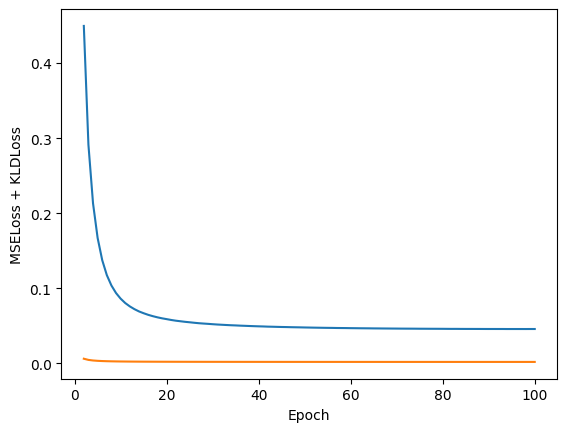

In [22]:
n=len(history['total_train_curve'])
epoch=[i for i in range(2,n+1)]
plt.plot(epoch,history['total_train_curve'][1:],label="Training curve")
plt.plot(epoch,history['total_val_curve'][1:],label="Validation curve")

plt.ylabel("MSELoss + KLDLoss")
plt.xlabel("Epoch")

plt.show()

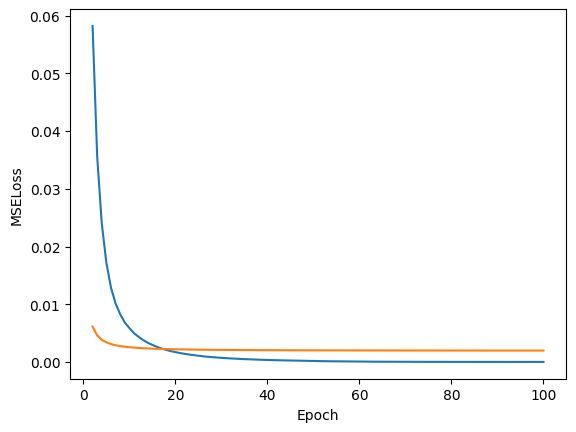

In [23]:
n=len(history['total_train_curve'])
epoch=[i for i in range(2,n+1)]
plt.plot(epoch,history['recons_train_curve'][1:],label="Training curve")
plt.plot(epoch,history['recons_val_curve'][1:],label="Validation curve")

plt.ylabel("MSELoss")
plt.xlabel("Epoch")

plt.show()

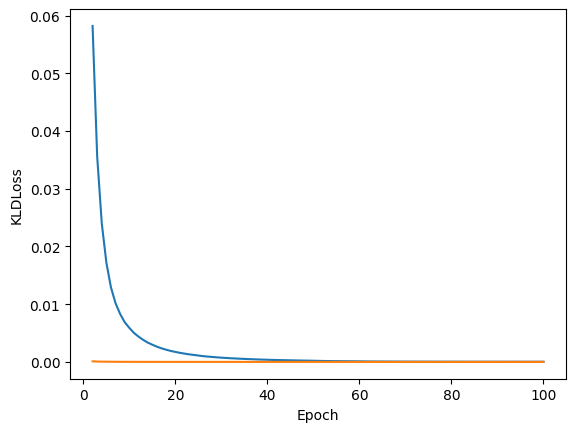

In [24]:
n=len(history['total_train_curve'])
epoch=[i for i in range(2,n+1)]
plt.plot(epoch,history['kld_train_curve'][1:],label="Training curve")
plt.plot(epoch,history['kld_val_curve'][1:],label="Validation curve")

plt.ylabel("KLDLoss")
plt.xlabel("Epoch")

plt.show()

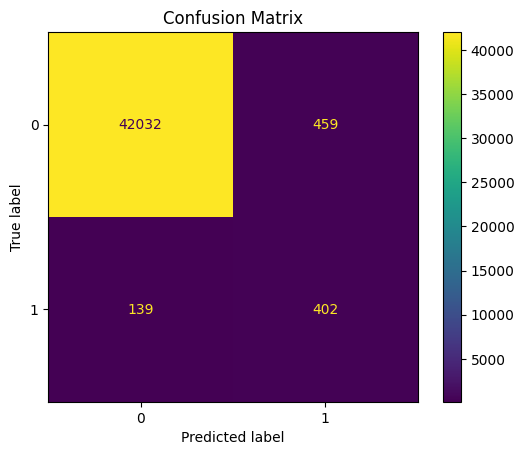

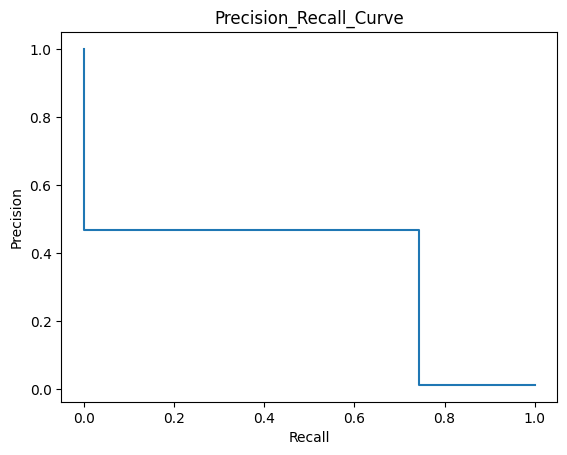

roc_auc 0.8661330521618344


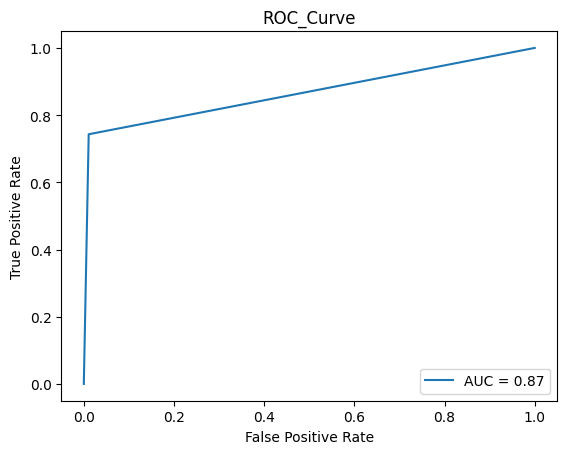

   f1_score  accuracy_score  precision_score  recall_score
0  0.573466        0.986103         0.466899      0.743068


In [25]:
criterion=nn.MSELoss(reduction='none') # Fonction de calcul de score d'anomalie
ypred=model.predict(test_loader,loss_fn=criterion)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

Visualisation TSNE

In [26]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['Class', 'Time'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [27]:
#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_dataset = AE_Dataset(df)
loader=DataLoader(dataset=pytorch_dataset,batch_size=10)

In [28]:
viz_y = model.predict(loader)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [29]:
import pickle
src_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src"

In [30]:
with open(src_path + "/X_embedded_creditcard.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [31]:
with open(src_path + "/embedded_index_creditcard.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'Variational auto encoder')

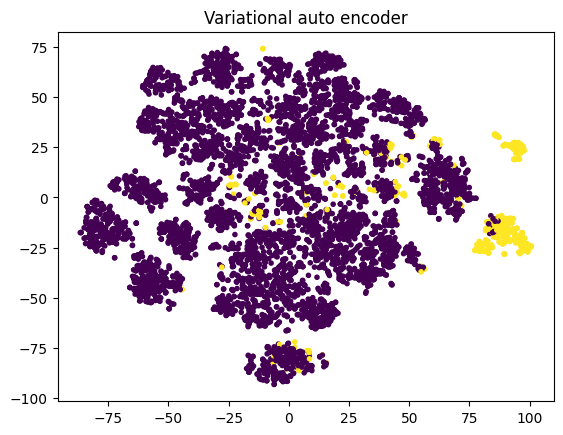

In [32]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("Variational auto encoder")

backdoor analysis

In [36]:
# Reprodductibilité
torch.manual_seed(42)

# Creation Dataset
file_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/UNSW_NB15_traintest_backdoor.csv"
#file_path = "/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv"
dataset = CustomDataset(file_path=file_path,scaler=MinMaxScaler())

xtrain, ytrain = dataset.get_train_data()
xtest, ytest = dataset.get_test_data()


#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_train_dataset = AE_Dataset(xtrain)
pytorch_test_dataset = AE_Dataset(xtest)
train_loader=DataLoader(dataset=pytorch_train_dataset,batch_size=100)
test_loader=DataLoader(dataset=pytorch_test_dataset,batch_size=10)

#Creation de modeèle
model=VariationalAutoEncoder(input_size=196,latent_size=10,output_size=196,contamination=0.02,dropout=0.3,device="cuda")

#Creation des paramètres d'entrînement du modèle
optimizer=optim.SGD(lr=1e-2, params=model.parameters(),momentum=0.9) # Optimiseur
scheduler = LinearLR(optimizer, start_factor=1e-1, end_factor=1e-4, total_iters=100) # Permet de changer le learning rate au cours de l'apprentissage

                                                                                    #Plus on se rapproche du minimun plus le learning devient faible afin d'éviter les rebond et d'assurer la convergence vers le minimum


history=model.fit(train_loader,test_loader,optimizer,scheduler,epochs=100)#Entraînement du modèle

EPOCHS : 1
total_Loss 1.6296310783177614 vs total_Validation_loss  0.10826454383422093
EPOCHS : 2
total_Loss 0.6530327112972736 vs total_Validation_loss  0.058590777018861756
EPOCHS : 3
total_Loss 0.41409509383141996 vs total_Validation_loss  0.040613934925072884
EPOCHS : 4
total_Loss 0.3158933015167713 vs total_Validation_loss  0.03224003723033341
EPOCHS : 5
total_Loss 0.26265560775995256 vs total_Validation_loss  0.0274627153366465
EPOCHS : 6
total_Loss 0.23024074975401163 vs total_Validation_loss  0.02448460146712471
EPOCHS : 7
total_Loss 0.20769393475726247 vs total_Validation_loss  0.022418275331502337
EPOCHS : 8
total_Loss 0.19061903979629277 vs total_Validation_loss  0.02096312495330012
EPOCHS : 9
total_Loss 0.1781682837381959 vs total_Validation_loss  0.019855980824310098
EPOCHS : 10
total_Loss 0.16825269855558872 vs total_Validation_loss  0.01906042682241344
EPOCHS : 11
total_Loss 0.16012461364269256 vs total_Validation_loss  0.01838503707103042
EPOCHS : 12
total_Loss 0.153589

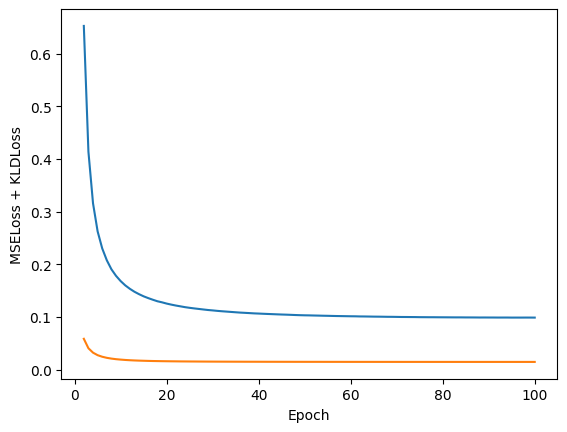

In [38]:
n=len(history['total_train_curve'])
epoch=[i for i in range(2,n+1)]
plt.plot(epoch,history['total_train_curve'][1:],label="Training curve")
plt.plot(epoch,history['total_val_curve'][1:],label="Validation curve")

plt.ylabel("MSELoss + KLDLoss")
plt.xlabel("Epoch")

plt.show()

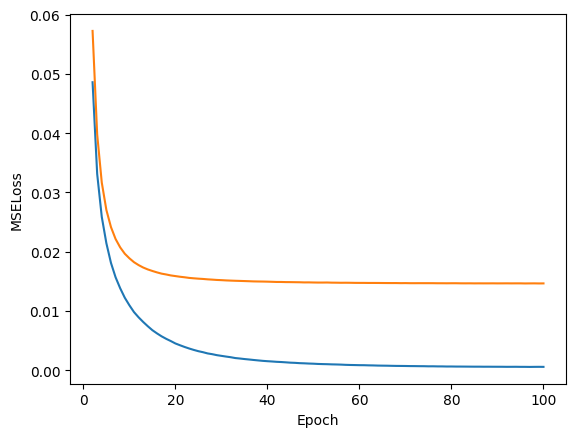

In [39]:
n=len(history['total_train_curve'])
epoch=[i for i in range(2,n+1)]
plt.plot(epoch,history['recons_train_curve'][1:],label="Training curve")
plt.plot(epoch,history['recons_val_curve'][1:],label="Validation curve")

plt.ylabel("MSELoss")
plt.xlabel("Epoch")

plt.show()

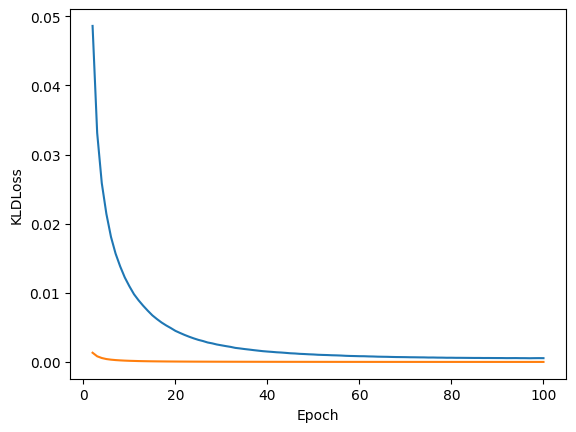

In [40]:
n=len(history['total_train_curve'])
epoch=[i for i in range(2,n+1)]
plt.plot(epoch,history['kld_train_curve'][1:],label="Training curve")
plt.plot(epoch,history['kld_val_curve'][1:],label="Validation curve")

plt.ylabel("KLDLoss")
plt.xlabel("Epoch")

plt.show()

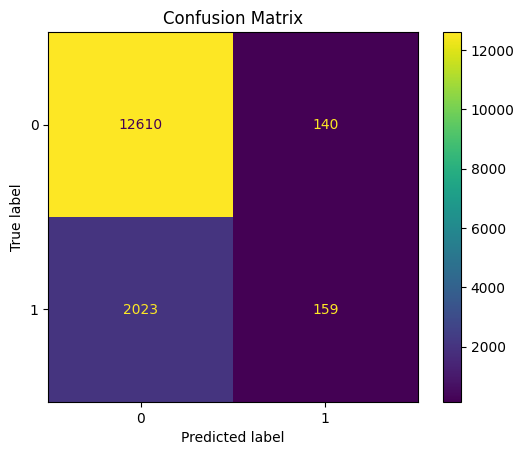

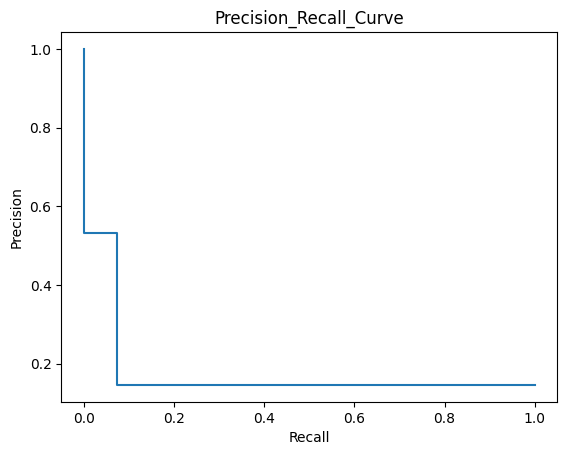

roc_auc 0.5309442677162524


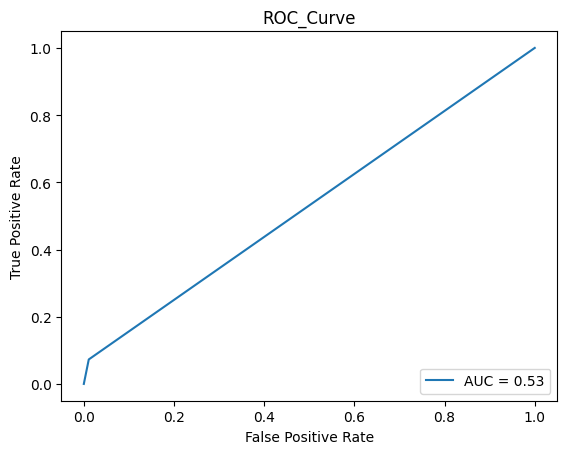

   f1_score  accuracy_score  precision_score  recall_score
0  0.128174        0.855143         0.531773      0.072869


In [41]:
ypred=model.predict(test_loader)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

visualisation tsne backdoor

In [42]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/UNSW_NB15_traintest_backdoor.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['class'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [43]:
#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_dataset = AE_Dataset(df)
loader=DataLoader(dataset=pytorch_dataset,batch_size=10)

In [44]:
viz_y = model.predict(loader)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [45]:
import pickle
src_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src"

In [46]:
with open(src_path + "/X_embedded_backdoor.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [47]:
with open(src_path + "/embedded_index_backdoor.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'Variational auto encoder')

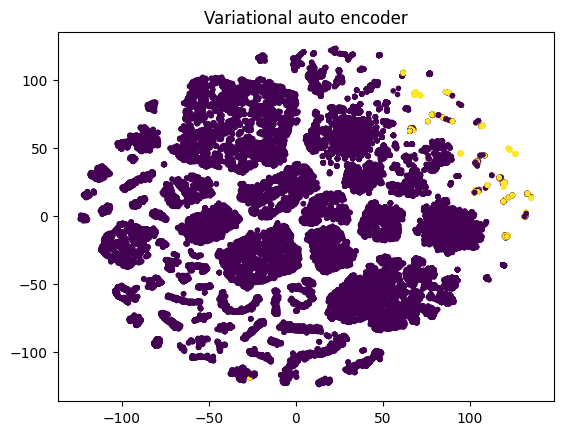

In [48]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("Variational auto encoder")